<a href="https://colab.research.google.com/github/saibhargavinukala/Siamese-Encoder/blob/main/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Siamese Encoder - Decoder with Attention
Large Language Models (LLMs) are frequently employed for rewriting or applying stylistic changes to text. The objective of this competition is to reconstruct the LLM prompt used to transform a specified text. To accomplish this, I will utilize an encoder-decoder architecture, specifically emphasizing attention mechanisms. Given that we have two inputs—the original text and the rewritten text—the encoder employs a siamese LSTM architecture.


In [ ]:
# Imports
import re
!pip install keras-nlp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_nlp

from pathlib import Path

from nltk.corpus import stopwords
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:

# Constants
# DATA = Path('/kaggle/') # This is not needed as you are providing the full path in rglob
# = Path('/content/drive/MyDrive/IV Project/train.csv')
TEST_DATA = Path('/content/drive/MyDrive/IV Project/test.csv')
SUBMISSION_DATA = Path('/content/drive/MyDrive/IV Project/sample_submission.csv')

VOCAB_SIZE = 5000
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 32

VOCAB_SIZE = 5000
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 32

1. Setup Modules & Dependencies


In [ ]:

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Setup Environment [OS]
import os
os.environ["KERAS_BACKEND"] = "jax" # the best performance can be achieved with JAX backend
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00" # avoid memory fragmentation on JAX backend

# Natural Language Processing + Machine Learning
import keras
import keras_nlp

# Math + Data Processing
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas() # progress bar for pandas

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='whitegrid', palette='viridis')

import plotly.graph_objs as go
import plotly.express as px
from IPython.display import display, Markdown

4. Data Upload¶
Data Format:

These datasets includes:

original_text: Input text/essay that needs to be transformed.
rewrite_prompt: Prompt/Instruction that was used in the Gemma LM to transform original_text. This is also our target for this competition.
rewritten_text: Output text that was generated by the Gemma model.

In [ ]:
# `LLM Prompt Recovery - Synthetic Datastore dataset` by @dschettler8845
df1 = pd.read_csv("/content/drive/MyDrive/IV Project/gemma1000_w7b.csv")
df1 = df1[["original_text", "rewrite_prompt", "gemma_7b_rewritten_text_temp0"]]
df1 = df1.rename(columns={"gemma_7b_rewritten_text_temp0":"rewritten_text"})

# `3000 Rewritten texts - Prompt recovery Challenge` by @dipamc77
df2 = pd.read_csv("/content/drive/MyDrive/IV Project/prompts_0_500_wiki_first_para_3000.csv")

# Merge all datasets
df = pd.concat([df1, df2], axis=0).dropna().reset_index(drop=True)
df.head(5)


,original_text,rewrite_prompt,rewritten_text
0,"Port-au-Prince, Haiti (CNN) -- Earthquake vict...",Turn this into an association to be joined.,"Sure, here is the association you requested:\n..."
1,Former secretary of state Hillary Clinton meet...,Convert this into a gain to be gained.,"Sure, here is the gain to be gained from the t..."
2,The opinions expressed by columnists are their...,Frame this as a political debate.,## The Obama Legacy: A Tale of Two Sides\n\nTh...
3,BIGBANG is one of those musical entities that ...,Imagine this as a mathematician's equation.,"Sure, here is the equation:\n\n**BIGBANG's imp..."
4,WHAT?!??! I know. That’s what you’re saying ri...,Frame this as an accountant's thrilling advent...,"Sure, here's the framed text as an accountant'..."


In [ ]:
df.shape

(3995, 3)

In [ ]:
df['max_len'] = df.apply(lambda row: max(len(row['original_text']), len(row['rewrite_prompt']), len(row['rewritten_text'])), axis=1)

In [ ]:
df = df[df['max_len'] <= 2000]
df.shape

(3912, 4)

In [ ]:
df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
max_len,3912.000000,645.411554,324.323789,79.000000,488.000000,582.000000,680.000000,1991.000000


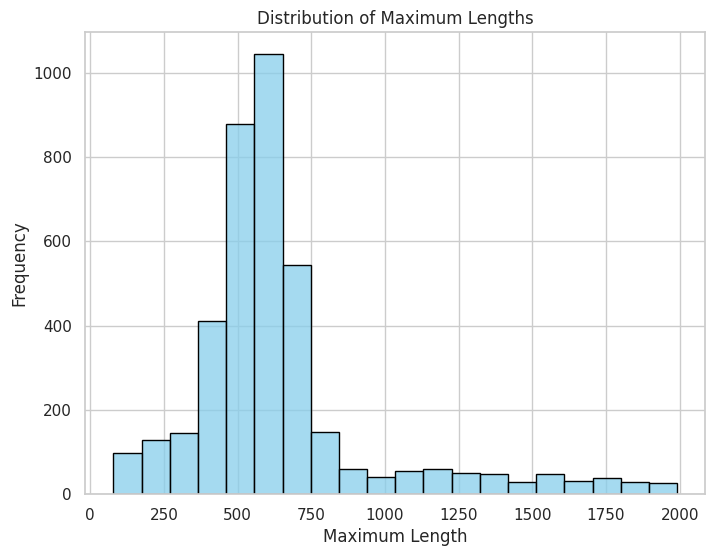

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['max_len'], bins=20, color='skyblue', edgecolor='black', kde=False)
plt.title('Distribution of Maximum Lengths')
plt.xlabel('Maximum Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
df['max_len'].mean()


645.411554192229

In [ ]:
# Constants

TRAIN_DATA = df
TEST_DATA = Path('/content/drive/MyDrive/IV Project/test.csv')
SUBMISSION_DATA = Path('/content/drive/MyDrive/IV Project/sample_submission.csv')

VOCAB_SIZE = 5000
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 32

In [ ]:
# Functions
def clean_text(text: str) -> str:
    """
    Clean text by removing unwanted characters or spaces.

    Args:
        text (str): The text to clean.

    Returns:
        str: The cleaned text.
    """
    # Remove unwanted characters (\n, \r, \t)
    cleaned_text = re.sub(r"[\n\r\t]", "", text)
    # Replace space between ' with no space
    cleaned_text = re.sub(r"\s*['’]\s*", r"'", cleaned_text)

    return cleaned_text

def pred_generation(original_text: str, rewritten_text: str, model: Model, text_vectorization: layers.TextVectorization) -> str:
    """
    Generate text using model predictions. Based on model token, the generation
    loop is broke.

    Args:
        orginal_text (str): The original text used by the encoder.
        rewritten_text (str): The rewritten text by Gemma used by the encoder.
        model (Model): The model used to make predictions.
        text_vectorization (TextVectorization): The adapted layers of prompt vocabulary used to vectorized text.

    Returns:
        str: The model prediction for the rewrite prompt.
    """
    generation = ""

    for word_idx in range(MAX_SEQ_LENGTH):
        # Set text to array in order to pass them into the encoder inputs
        X_or = tf.constant([original_text])
        X_re = tf.constant([rewritten_text])

        # Get decoder inputs
        X_dec = tf.constant(["startofseq " + generation])

        # Get models predictions (last token's proba)
        y_proba = model.predict((X_or, X_re, X_dec), verbose=0)[0, word_idx]
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vectorization.get_vocabulary()[predicted_word_id]

        # Break the generation loop if the model predict the end of sequence
        if predicted_word == "endofseq":
            break

        # Add the new generated word
        generation += " " + predicted_word

    return generation.strip()

EDA

In [ ]:

#Read the data
df_train = df#pd.read_csv(TRAIN_DATA)
df_train.head()
df_train.shape
# Drop the id (unnecessary)
#df_train.drop("dataset_id", axis=1, inplace=True)


(3912, 4)

In [ ]:

# Clean the text data
for col in ['original_text', 'rewrite_prompt', 'rewritten_text']: # Explicitly list the text columns
    df_train[col] = df_train[col].str.strip().apply(clean_text)


The first task is to examine the length of the text sequences in the original, rewritten, and rewrite text. This will be a limiting factor because of the GPU's low memory access on Kaggle, which restricts our ability to use excessively long sequences.

It appears that most of the texts are quite short, so reducing the sequence length to a maximum of 512 in this notebook should not pose a significant disadvantage.

We can also look at the most frequent word in the rewrite prompts:

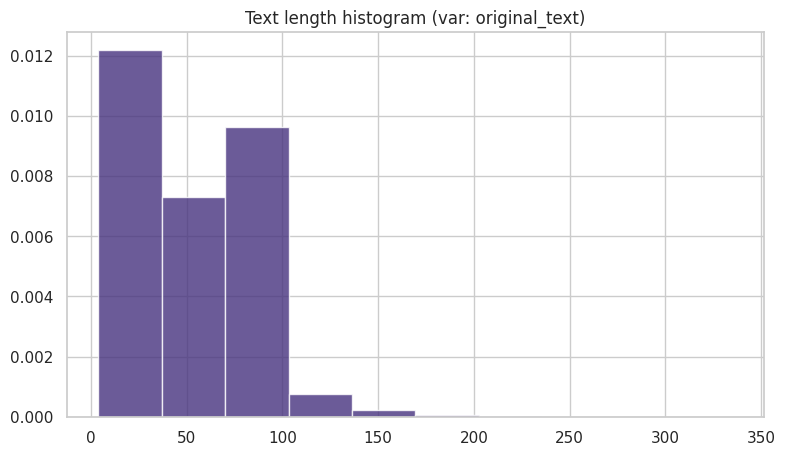

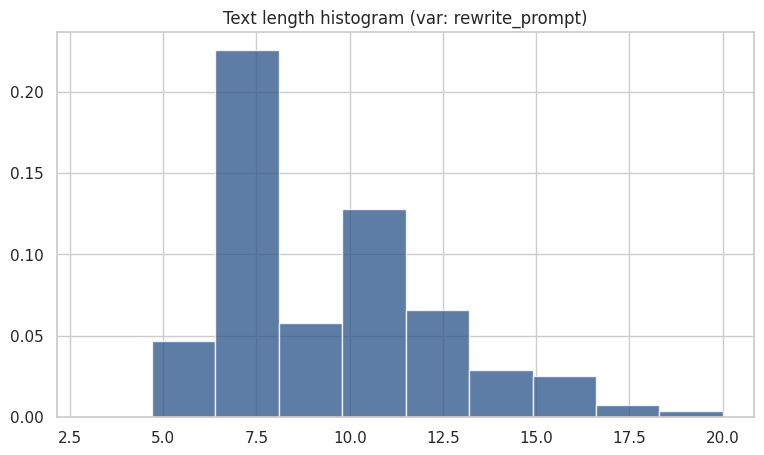

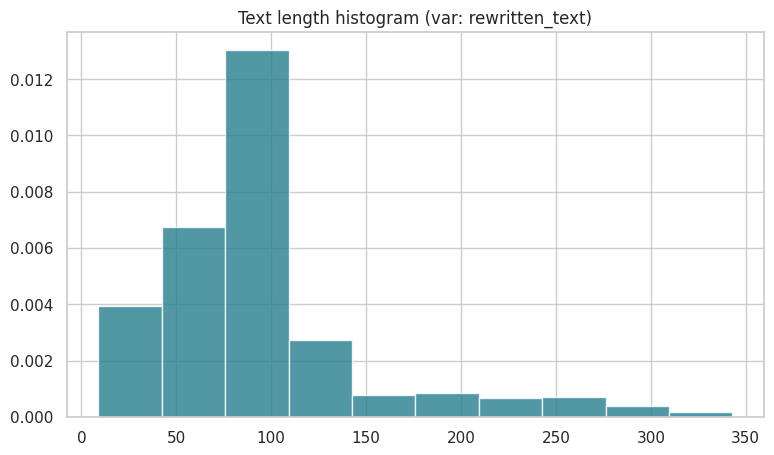

Skipping column 'max_len' as it does not contain string data.


In [ ]:
for i, col in enumerate(df_train.columns.to_list()):
    # Check if the column contains string data before applying string methods
    if df_train[col].dtype == 'object':  # 'object' dtype often represents strings
        lengths = df_train[col].str.rsplit(" ").apply(lambda x: len(x))

        plt.figure(figsize=(9, 5))
        plt.hist(lengths, density=True, alpha=0.8, color=f"C{i}")
        plt.title(f"Text length histogram (var: {col})")
        plt.show()
    else:
        print(f"Skipping column '{col}' as it does not contain string data.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


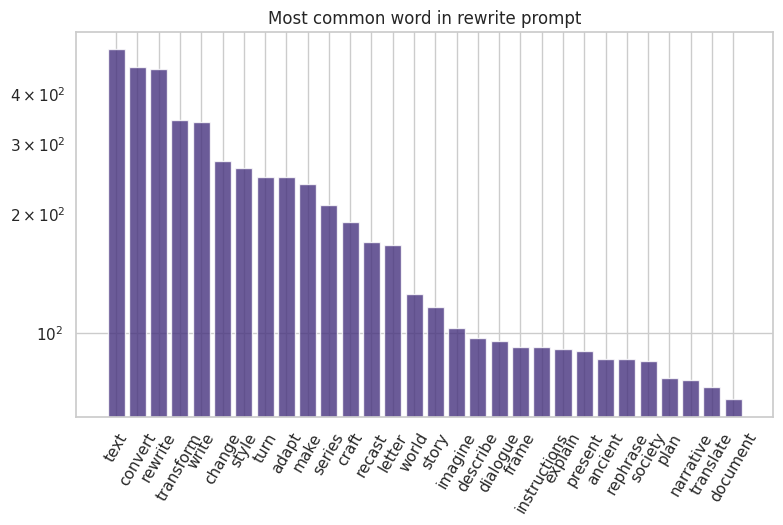

In [ ]:
import nltk
nltk.download('stopwords')

# Get the most common word in the rewrite prompts
stop_words = set(stopwords.words('english'))
most_common = df_train["rewrite_prompt"].apply(
    lambda x: [w.lower() for w in re.sub(r"[^\w\s]","", x).rsplit(" ") if not w.lower() in stop_words]
)

most_common = most_common.explode().value_counts()[:30]

plt.figure(figsize=(9, 5))
plt.bar(most_common.index, most_common.values, alpha=0.8, log=True)
plt.title("Most common word in rewrite prompt")
plt.xticks(rotation=60)
plt.show()

Preprocessing¶
We create two text vectorizers, one for the encoder and another for the decoder. An additional constraint due to the GPU's limited memory access in Kaggle is the maximum number of tokens we can set in the text vectorizers (5000 in this notebook).

Once the text vectorizers are defined, we adapt them to the available texts. For the decoder, we manually add startofseq and endofseq tokens, which are necessary for text generation.

In [ ]:
# Define the TextVectorization layers for each model inputs
encoder_veclayer = layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_SEQ_LENGTH)
decoder_veclayer = layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_SEQ_LENGTH)

# Adapt each layers to the text vocabulary
encoder_veclayer.adapt(df_train['original_text'].values)
# Artificially add start of sequence and end of sequence tokens
decoder_veclayer.adapt([f"startofseq {t} endofseq" for t in df_train['rewrite_prompt'].values])

In [ ]:
# Check some vocabulary
print(encoder_veclayer.get_vocabulary()[:10])
print(decoder_veclayer.get_vocabulary()[:10])

['', '[UNK]', 'the', 'of', 'in', 'a', 'and', 'is', 'to', 'was']
['', '[UNK]', 'a', 'startofseq', 'endofseq', 'it', 'as', 'into', 'this', 'the']


In [ ]:
# Split into train and validation set
X_train_or, X_val_or, X_train_re, X_val_re, Y_train, Y_val = train_test_split(
    df_train['original_text'].values,
    df_train['rewritten_text'].values,
    df_train['rewrite_prompt'].values,
    train_size=0.8,
    random_state=42
)

In [ ]:
# Prepare the train arrays
X_train_or = tf.constant(X_train_or)
X_val_or = tf.constant(X_val_or)
X_train_re = tf.constant(X_train_re)
X_val_re = tf.constant(X_val_re)

# Prepare the target array
X_train_dec = tf.constant([f"startofseq {t}" for t in Y_train])
X_val_dec = tf.constant([f"startofseq {t}" for t in Y_val])

Y_train = decoder_veclayer([f"{t} endofseq" for t in Y_train])
Y_val = decoder_veclayer([f"{t} endofseq" for t in Y_val])

Modeling¶

After preparing the necessary arrays for modeling, we encode the data using text vectorizers and use embeddings to project our vocabulary onto 512-dimensional vectors.

Embeddings are dense vector representations of words or tokens in NLP. Each word is mapped to a unique vector in a continuous space, capturing semantic relationships based on context. They enhance model performance by representing words in a way that supports tasks like classification and text generation. During training, embeddings are learned by predicting context words, adjusting vectors to capture semantic similarities from text data. This enables models to process textual data efficiently while preserving semantic meaning.

In [ ]:
# Define input sequences
encoder_inputs_or = layers.Input(shape=[], dtype=tf.string)
encoder_inputs_re = layers.Input(shape=[], dtype=tf.string)
decoder_inputs = layers.Input(shape=[], dtype=tf.string)

encoder_input_or_ids = encoder_veclayer(encoder_inputs_or)
encoder_input_re_ids = encoder_veclayer(encoder_inputs_re)
decoder_input_ids = decoder_veclayer(decoder_inputs)

# Embeddings
encoder_embed = layers.Embedding(VOCAB_SIZE, 512)
decoder_embed = layers.Embedding(VOCAB_SIZE, 512)

encoder_embeddings_or = encoder_embed(encoder_input_or_ids)
encoder_embeddings_re = encoder_embed(encoder_input_re_ids)
decoder_embeddings = decoder_embed(decoder_input_ids)

Now, we build the encoder part using the preceding embeddings. The encoder incorporates a siamese bidirectional LSTM. It processes input data in two ways: from the beginning to the end (forward direction) and from the end to the beginning (backward direction). By processing input sequences in these two directions, a bidirectional LSTM can capture dependencies from both past and future states, enabling better context understanding and representation. The siamese part helps to capture information from both the original text and the rewritten text.

In [ ]:
# Encoder
encoder_or = layers.Bidirectional(layers.LSTM(256, return_sequences=True))
encoder_re = layers.Bidirectional(layers.LSTM(256, return_sequences=True))

encoder_or_out = encoder_or(encoder_embeddings_or)
encoder_re_out = encoder_re(encoder_embeddings_re)

concat = layers.Concatenate()
concat_out = concat([encoder_or_out, encoder_re_out])

encoder = tf.keras.layers.LSTM(512, return_state=True, return_sequences=True)
encoder_outputs, *encoder_state = encoder(concat_out)

After building the encoder, the next step is to construct the decoder part. The decoder utilizes LSTM cells applied to the embeddings calculated in the previous step. This setup enables the decoder to generate output sequences based on the encoded information from the original and rewritten texts.

In [ ]:
# Decoder
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

Now, let's focus on implementing the attention mechanism in our model before constructing the final dense prediction layers. Attention mechanisms are essential for enabling models to concentrate on specific parts of the input during prediction. They work by allowing the model to assign varying weights or importance to different input elements based on their relevance to the task at hand. This approach is particularly valuable when not all input elements are equally significant for the prediction, as in our case.

Incorporating attention allows models to selectively attend to pertinent information, enhancing performance by effectively capturing dependencies and relationships within the data. This selective attention mechanism is instrumental in achieving improved accuracy and generalization, particularly in tasks involving sequential data like text.

In [ ]:
# Attention
attention_layer = layers.Attention(dropout=0.2)
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

output_layer = layers.Dense(VOCAB_SIZE, activation="softmax")
Y_proba = output_layer(attention_outputs)

Now we can build our model, and compile it using Nadam optimizer (it use Nesterov trick and generally converge slightly faster than Adam optimizer) with a low learning rate (1e-4).


In [ ]:
# Model
model = Model(
    inputs=[encoder_inputs_or, encoder_inputs_re, decoder_inputs],
    outputs=[Y_proba]
)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Nadam(learning_rate=1e-4),
    metrics=["accuracy"]
)

In [ ]:
# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 512)            │              0 │ input_layer[0][0],     │
│ (TextVectorization)       │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 512, 512)       │      2,560,000 │ text_vectorization[0]… │
│                           │                        │                │ text_vectorization[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512, 512)       │      1,574,912 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 512, 512)       │      1,574,912 │ embedding[1][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 512)            │              0 │ input_layer_2[0][0]    │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512, 1024)      │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 512, 512)       │      2,560,000 │ text_vectorization_1[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 512, 512),     │      3,147,776 │ concatenate[0][0]      │
│                           │ (None, 512), (None,    │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 512, 512)       │      2,099,200 │ embedding_1[0][0],     │
│                           │                        │                │ lstm_2[0][1],          │
│                           │                        │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 512, 512)       │              0 │ lstm_3[0][0],          │
│                           │                        │                │ lstm_2[0][0]           │
├──────────────────────

 Total params: 16,081,800 (61.35 MB)

 Trainable params: 16,081,800 (61.35 MB)

 Non-trainable params: 0 (0.00 B)

Now, we can proceed with training the model, which may take a considerable amount of time due to the complexity of the architecture (especially with attention computations, which have a time complexity of O(n^2)). Additionally, it's important to note that using accuracy as a metric may not be ideal for evaluating text generation tasks, which can lead to generous score given by embedding vectors for incorrect answers.

In [ ]:
# Train the model
history = model.fit(
    (X_train_or, X_train_re, X_train_dec),
    Y_train,
    epochs=15,
    validation_data=((X_val_or, X_val_re, X_val_dec), Y_val),
    batch_size=BATCH_SIZE,
)

Epoch 1/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 59s 516ms/step - accuracy: 0.9282 - loss: 3.2569 - val_accuracy: 0.9797 - val_loss: 0.2190
Epoch 2/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 51s 522ms/step - accuracy: 0.9794 - loss: 0.2192 - val_accuracy: 0.9797 - val_loss: 0.2088
Epoch 3/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 534ms/step - accuracy: 0.9793 - loss: 0.2119 - val_accuracy: 0.9797 - val_loss: 0.2060
Epoch 4/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 538ms/step - accuracy: 0.9794 - loss: 0.2079 - val_accuracy: 0.9797 - val_loss: 0.2048
Epoch 5/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 55s 562ms/step - accuracy: 0.9795 - loss: 0.2062 - val_accuracy: 0.9797 - val_loss: 0.2029
Epoch 6/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 567ms/step - accuracy: 0.9795 - loss: 0.1727 - val_accuracy: 0.9800 - val_loss: 0.1151
Epoch 7/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 567ms/step - accuracy: 0.9809 - loss: 0.1142 - val_accuracy: 0.9834 - val_loss: 0.1028
Epoch 8/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 567ms/step - accuracy: 0.9832 - loss: 0.1028 - val_accu

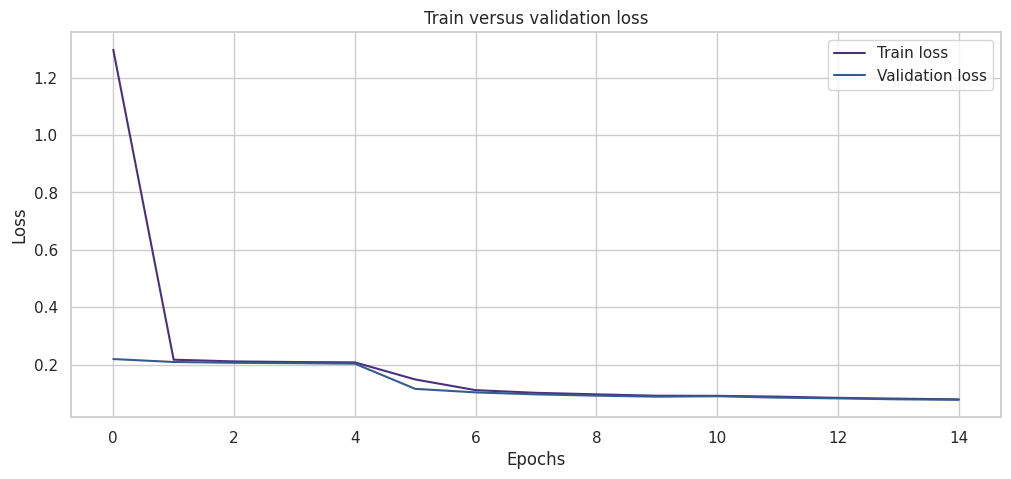

In [ ]:
# Analyze the train and validation accuracy
plt.figure(figsize=(12,5))
plt.plot(
    history.history['loss'],
    label="Train loss"
)
plt.plot(
    history.history['val_loss'],
    label="Validation loss"
)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train versus validation loss")
plt.legend()
plt.show()

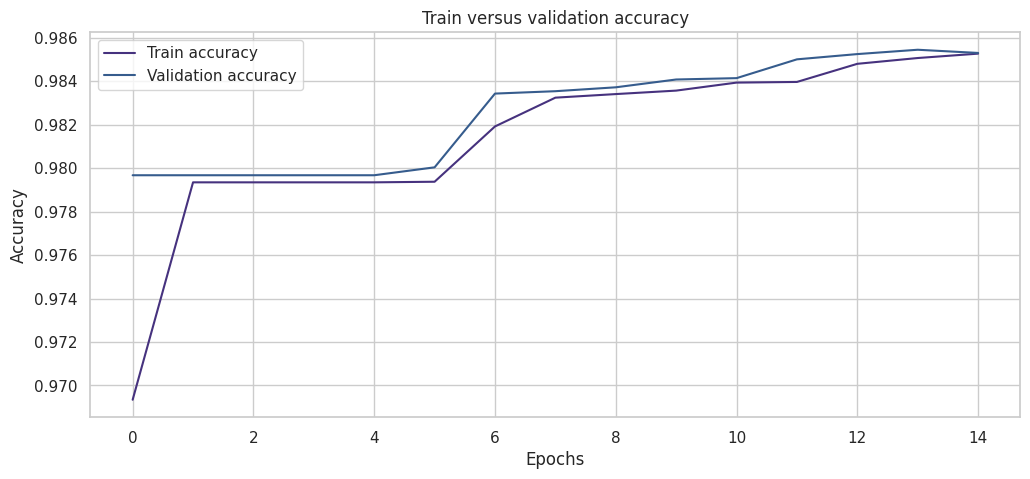

In [ ]:
# Analyze the train and validation accuracy
plt.figure(figsize=(12,5))
plt.plot(
    history.history['accuracy'],
    label="Train accuracy"
)
plt.plot(
    history.history['val_accuracy'],
    label="Validation accuracy"
)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train versus validation accuracy")
plt.legend()
plt.show()

The result seems good, so lets look at prediction of the only example of the test set!

In [ ]:

# Generate predictions in batches to avoid OOM error
batch_size = 32  # Adjust as needed based on your GPU memory
num_batches = (X_val_or.shape[0] + batch_size - 1) // batch_size

predictions = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, X_val_or.shape[0])

    # Use X_val_dec instead of initial_decoder_input
    batch_predictions = model.predict(
        [X_val_or[start_idx:end_idx],
         X_val_re[start_idx:end_idx],
         X_val_dec[start_idx:end_idx]], # Changed this line
        verbose=0  # Suppress prediction logs for cleaner output
    )
    predictions.extend(batch_predictions)


# Convert predictions to text (after all batches are processed)
def decode_predictions(predictions):
    # Assuming vectorize_layer is decoder_veclayer
    # Flatten the predictions to a 1D array
    predictions = predictions.reshape(-1, predictions.shape[-1])
    # Get the indices of the maximum values along the last axis (vocabulary size)
    predicted_word_ids = np.argmax(predictions, axis=-1)
    # Convert the predicted word IDs to words using the decoder's vocabulary
    decoded_words = [decoder_veclayer.get_vocabulary()[word_id] for word_id in predicted_word_ids]
    # Join the decoded words into a single string
    decoded_text = " ".join(decoded_words)
    return decoded_text

decoded_predictions = [decode_predictions(pred) for pred in predictions]

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu_score(reference, hypothesis):
    # Convert reference (EagerTensor) to string
    reference_text = " ".join([decoder_veclayer.get_vocabulary()[token_id]
                               for token_id in reference.numpy() if token_id != 0])
    return sentence_bleu([reference_text.split()], hypothesis.split())

bleu_scores = [
    compute_bleu_score(ref, hyp)
    for ref, hyp in zip(Y_val, decoded_predictions)
]
average_bleu = np.mean(bleu_scores)
print(f"Average BLEU Score: {average_bleu}")

Average BLEU Score: 9.033900398243081e-156


In [ ]:
!pip install rouge-score
from rouge_score import rouge_scorer

def compute_rouge_scores(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    # Convert reference (EagerTensor) to string
    reference_text = " ".join([decoder_veclayer.get_vocabulary()[token_id]
                               for token_id in reference.numpy() if token_id != 0])
    return scorer.score(reference_text, hypothesis)  # Pass reference_text instead of reference

rouge_scores = [
    compute_rouge_scores(ref, hyp)
    for ref, hyp in zip(Y_val, decoded_predictions)
]
average_rouge = {
    'rouge1': np.mean([score['rouge1'].fmeasure for score in rouge_scores]),
    'rouge2': np.mean([score['rouge2'].fmeasure for score in rouge_scores]),
    'rougeL': np.mean([score['rougeL'].fmeasure for score in rouge_scores]),
}
print(f"Average ROUGE Scores: {average_rouge}")


Average ROUGE Scores: {'rouge1': 0.28654284940345337, 'rouge2': 0.014222714127670058, 'rougeL': 0.2840856908998019}


In [ ]:
#in submission this is giving only one prompt
#Prediction
# Read the test data
df_test = pd.read_csv(TEST_DATA)
df_test.head()

# Assuming df_test has an 'id' column

# Check if df_test has only one row:
if df_test.shape[0] == 1:
    # If it has only one row, take the first element of decoded_predictions
    df_submission = pd.DataFrame({'id': df_test['id'], 'rewrite_prompt': [decoded_predictions[0]]})
else:
    # If it has multiple rows, proceed as before (but make sure decoded_predictions has the correct length)
    if len(decoded_predictions) != df_test.shape[0]:
        print(f"Warning: Number of predictions ({len(decoded_predictions)}) does not match number of test samples ({df_test.shape[0]})")
    df_submission = pd.DataFrame({'id': df_test['id'], 'rewrite_prompt': decoded_predictions})

df_submission.to_csv('submission.csv', index=False)

In [ ]:
#this is giving for multiple rows
# Create a new 'id' column if it doesn't exist
if 'id' not in df.columns:
    df['id'] = np.arange(len(df))

# Get the indices used for validation
_, val_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Assuming 'decoded_predictions' from cell 33 contains the predicted prompts:
predictions_text = [p.replace('endofseq', '').strip() for p in decoded_predictions]

# Create a DataFrame using only the validation set IDs and predictions
df_submission = pd.DataFrame({'id': df.loc[val_indices, 'id'],
                               'predicted_prompt': predictions_text})

df_submission.to_csv('submission1.csv', index=False)

In [ ]:
#Prediction
# Read the test data
df_test = pd.read_csv(TEST_DATA)
df_test.head()

,id,original_text,rewritten_text
0,-1,The competition dataset comprises text passage...,Here is your shanty: (Verse 1) The text is rew...


In [ ]:
# Test generation of rewrite prompt for the test set for first element
res = pred_generation(
    df['original_text'].values[0],
    df['rewritten_text'].values[0],
    model,
    decoder_veclayer,
)

print(f"Rewrite prompt: {res}")

Rewrite prompt: rewrite it it a series


In [ ]:
# Initialize a list to store predictions
predictions = []

# Generate the rewrite prompt for the test set
for i in range(len(df)):
    if i % 500 == 0:
        print(f"Prediction on element {i}/{len(df)}")

    res = pred_generation(
        df['original_text'].values[i],
        df['rewritten_text'].values[i],
        model,
        decoder_veclayer,
    )

    predictions.append(res)

Prediction on element 0/3912
Prediction on element 500/3912
Prediction on element 1000/3912
Prediction on element 1500/3912
Prediction on element 2000/3912
Prediction on element 2500/3912
Prediction on element 3000/3912
Prediction on element 3500/3912


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu_score(reference, hypothesis):
    # Convert reference (EagerTensor) to string
    reference_text = " ".join([decoder_veclayer.get_vocabulary()[token_id]
                               for token_id in reference.numpy() if token_id != 0])
    return sentence_bleu([reference_text.split()], hypothesis.split())

# The 'predictions' list contains the predicted prompts (strings), not token IDs.
# You need to convert these prompts back into token IDs using the decoder_veclayer.

decoded_predictions = []
for prediction in predictions:
    # Tokenize the prediction using the decoder's text vectorization layer
    tokenized_prediction = decoder_veclayer(prediction)

    # Convert the token IDs back into words
    decoded_prediction = " ".join([decoder_veclayer.get_vocabulary()[token_id]
                                  for token_id in tokenized_prediction.numpy() if token_id != 0])
    decoded_predictions.append(decoded_prediction)


bleu_scores = [
    compute_bleu_score(ref, hyp)
    for ref, hyp in zip(Y_val, decoded_predictions)
]
average_bleu = np.mean(bleu_scores)
print(f"Average BLEU Score: {average_bleu}")

Average BLEU Score: 3.7897098440278443e-156


In [ ]:
!pip install rouge-score
from rouge_score import rouge_scorer

def compute_rouge_scores(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    # Convert reference (NumPy array) to string
    # Assuming decoder_veclayer has a get_vocabulary() method
    reference = " ".join([decoder_veclayer.get_vocabulary()[token_id]
                          for token_id in reference.numpy() if token_id != 0])
    return scorer.score(reference, hypothesis)

rouge_scores = [
    compute_rouge_scores(ref, hyp)
    for ref, hyp in zip(Y_val, decoded_predictions)
]
average_rouge = {
    'rouge1': np.mean([score['rouge1'].fmeasure for score in rouge_scores]),
    'rouge2': np.mean([score['rouge2'].fmeasure for score in rouge_scores]),
    'rougeL': np.mean([score['rougeL'].fmeasure for score in rouge_scores]),
}
print(f"Average ROUGE Scores: {average_rouge}")


Average ROUGE Scores: {'rouge1': 0.2068670133446646, 'rouge2': 0.019473573274188444, 'rougeL': 0.2068670133446646}


submission


In [ ]:
# Get submissions data
df_sub = pd.read_csv(SUBMISSION_DATA)

# Check if df_sub has only one row:
if df_sub.shape[0] == 1:
    # If it has only one row, take the first element of predictions
    df_sub['rewrite_prompt'] = [predictions[0]]
else:
    # If it has multiple rows, proceed as before
    # (but make sure predictions has the correct length)
    if len(predictions) != df_sub.shape[0]:
        print(f"Warning: Number of predictions ({len(predictions)}) "
              f"does not match number of test samples ({df_sub.shape[0]})")
    df_sub['rewrite_prompt'] = predictions

# Add default prompt when the model fail to make prediction
mean_prompt = "Improve this text using the writing style with maintaining the original meaning but altering the tone"
df_sub['rewrite_prompt'] = df_sub['rewrite_prompt'].map(lambda x: mean_prompt if len(x) == 0 else x)

In [ ]:
# Save as csv the result
df_sub.to_csv('submission2.csv', index=False)